In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Window version
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# M1 MAC version
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(DEVICE)

mps


In [4]:
BATCH_SIZE = 1
save_model_path = "result/CNN_deep_CIFAR10.pt"
transform = transforms.ToTensor()

test_DS = datasets.CIFAR10(root = 'your path/data', train=False, download=True, transform=transforms.ToTensor())
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [5]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.maxp = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.classifier = nn.Sequential(
            nn.Linear(128*12*12,512),
            nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.maxp(x)
        x = self.conv_block2(x)
        x = self.maxp(x)
        x = self.conv_block3(x)
        x = self.maxp(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return x

In [6]:
load_model = torch.load(save_model_path, map_location=DEVICE)
print(load_model)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1,

torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 128, 8, 8])


Text(0.5, 1.0, 'truck (automobile)')

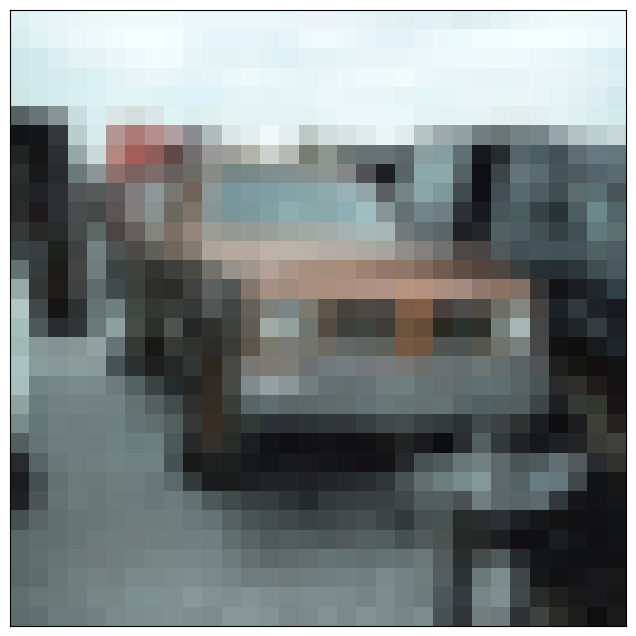

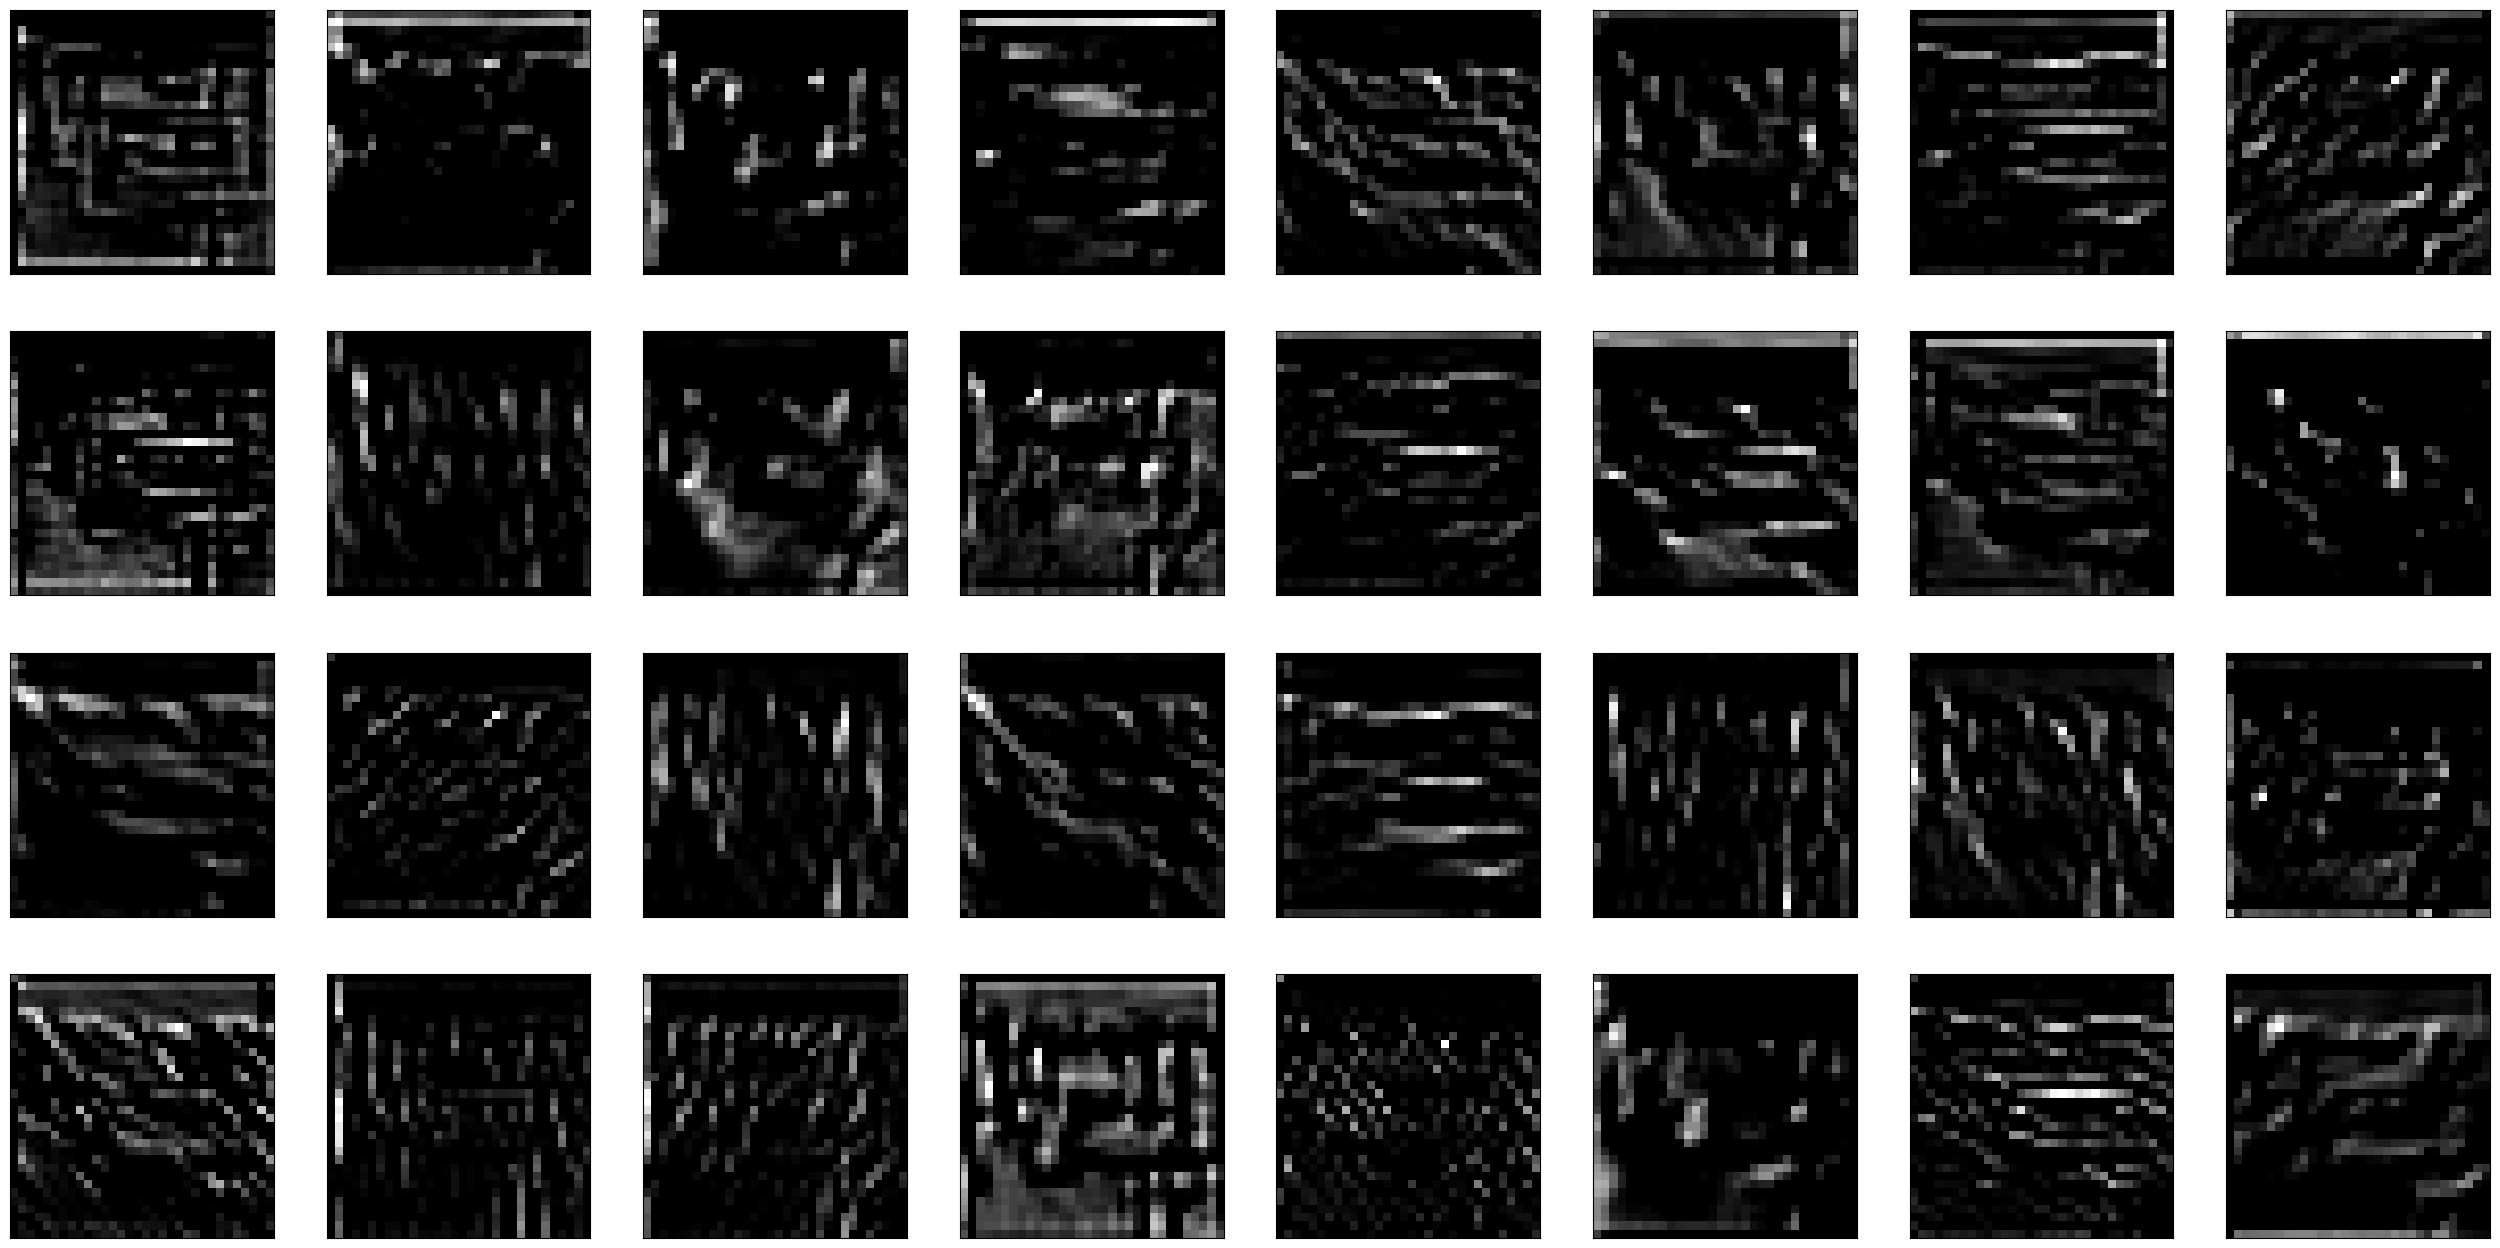

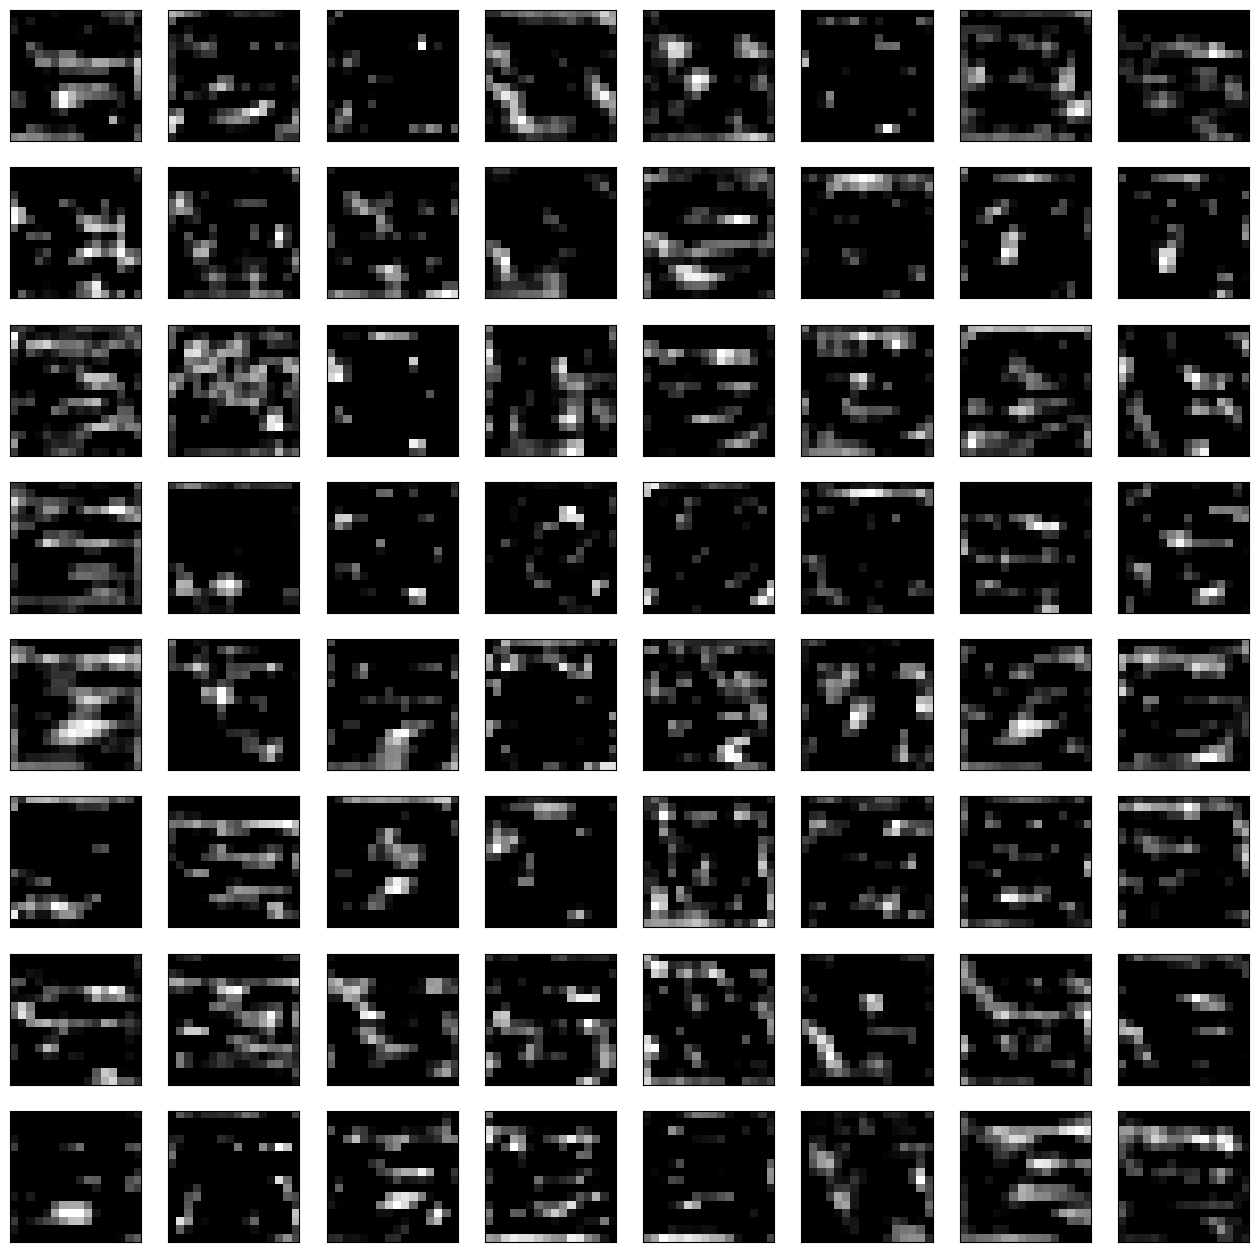

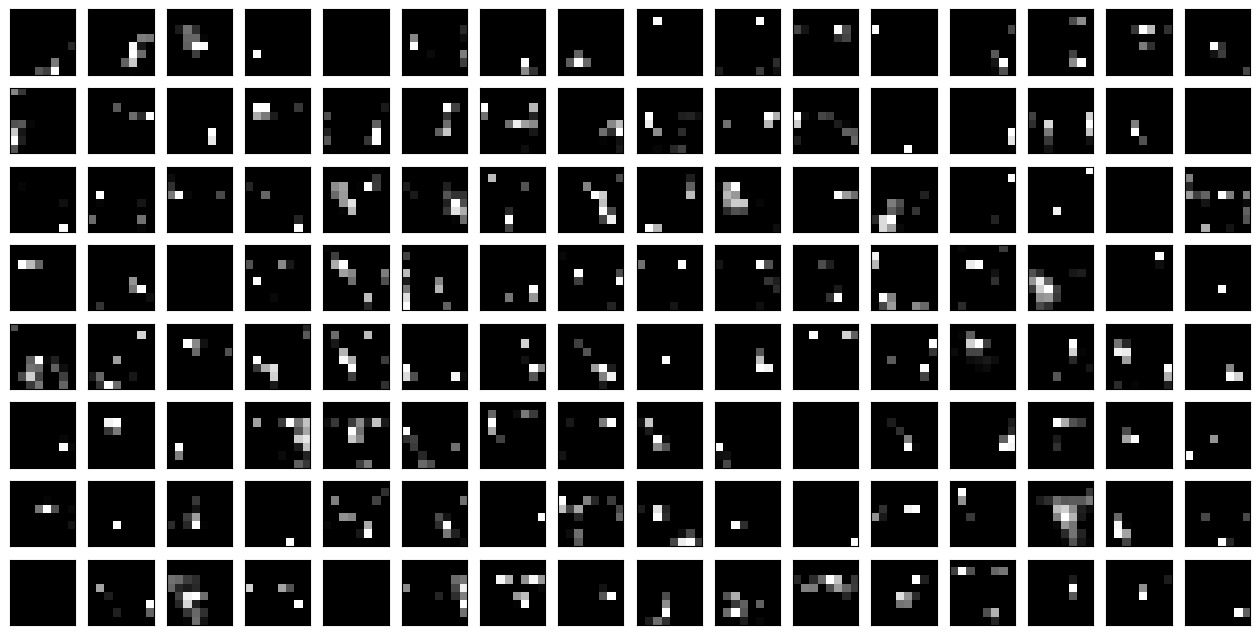

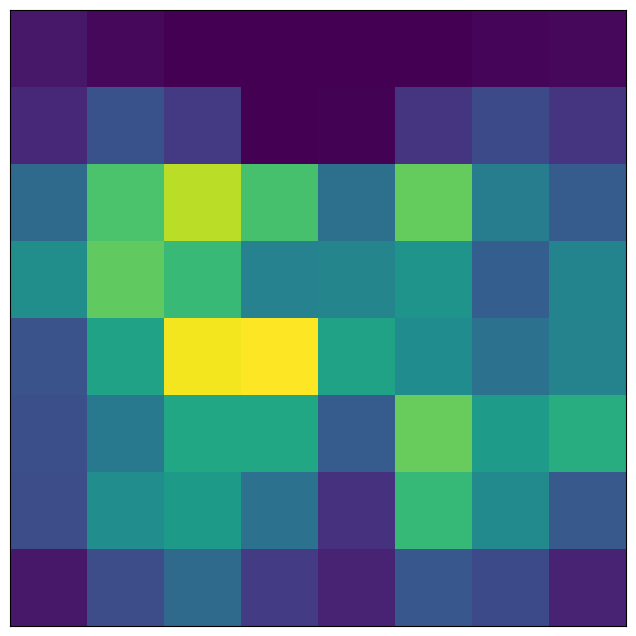

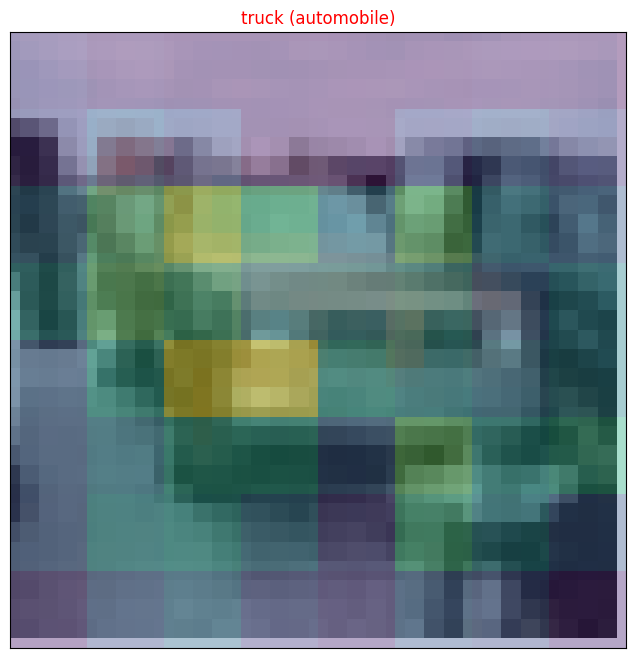

In [11]:
load_model.eval()
with torch.no_grad():
    x_batch, y_batch = next(iter(test_DL))
    x_batch = x_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)
    y_hat = load_model(x_batch)
    pred = y_hat.argmax(dim=1)

    feature_map1 = load_model.conv_block1(x_batch)
    feature_map2 = load_model.conv_block2(load_model.maxp(feature_map1))
    feature_map3 = load_model.conv_block3(load_model.maxp(feature_map2))

x_batch = x_batch.cpu()
feature_map1 = feature_map1.cpu()
feature_map2 = feature_map2.cpu()
feature_map3 = feature_map3.cpu()

plt.figure(figsize=(8,8))
plt.xticks([]); plt.yticks([]);
plt.imshow(x_batch[0,...].permute(1,2,0))

print(feature_map1.shape)
plt.figure(figsize=(32,16))
for idx in range(32):
    plt.subplot(4,8, idx+1, xticks=[], yticks=[])
    plt.imshow(feature_map1[0, idx, ...], cmap='gray')

print(feature_map2.shape)
plt.figure(figsize=(16,16))
for idx in range(64):
    plt.subplot(8,8,idx+1, xticks=[], yticks=[])
    plt.imshow(feature_map2[0, idx, ...], cmap='gray')

print(feature_map3.shape)
plt.figure(figsize=(16,8))
for idx in range(128):
    plt.subplot(8, 16, idx+1, xticks=[], yticks=[])
    plt.imshow(feature_map3[0, idx, ...], cmap='gray')

summed_map = feature_map3.sum(dim=1)
plt.figure(figsize=(8,8))
plt.xticks([]); plt.yticks([]);
plt.imshow(summed_map[0,...])

plt.figure(figsize=(8,8))
plt.xticks([]); plt.yticks([])
plt.imshow(x_batch[0,...].permute(1,2,0))
plt.imshow(summed_map[0,...], extent=[0,32,32,0], alpha=0.4)
pred_class = test_DS.classes[pred]
true_class = test_DS.classes[y_batch]
plt.title(f'{pred_class} ({true_class})', color='g' if pred_class == true_class else 'r')